---
## Mount the google Drive. 
---
1. Run the codes below
2. Click on the link provided
3. login with you google account
4. Copy and paste the given authorization codes to the textbox provided

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Click on the folder icon on the left.<br>
2. Navigate to the course folder<br>
3. Click on the menu button (three dots)
4. Click on "copy path".<br>
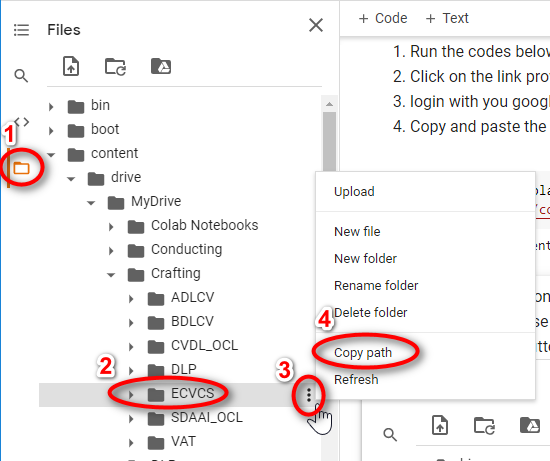
<br>
5. Paste the copied path into the code below.

In [2]:
course_path = "/content/drive/MyDrive/Crafting/ECVCS"

---
# Install the Google Client Library
---
Run this code only once!

In [3]:
!pip install --upgrade google-cloud-vision

Requirement already up-to-date: google-cloud-vision in /usr/local/lib/python3.7/dist-packages (2.3.2)


---
# Define a function to detect objects
---
This function will call the Vision API to perform the object detection.

In [8]:
# Imports the Google Cloud client library
from google.cloud import vision
import os
import io

# Provide the location to the Credential JSON file
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/My Drive/cloud_vision.json"

def detect_objects(path):
    # Instantiates a client
    client = vision.ImageAnnotatorClient()

    # The name of the image file to annotate
    file_name = path

    # Loads the image into memory
    with io.open(file_name, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    # Performs label detection on the image file
    response = client.object_localization(image=image)
    return response.localized_object_annotations

---
# Perform object detection
---

In [10]:
filename = course_path + "/our_people.jpg"
labels = detect_objects(filename)
print(labels)

[mid: "/m/07mhn"
name: "Pants"
score: 0.9262357950210571
bounding_poly {
  normalized_vertices {
    x: 0.8619949817657471
    y: 0.7045111656188965
  }
  normalized_vertices {
    x: 0.9609649181365967
    y: 0.7045111656188965
  }
  normalized_vertices {
    x: 0.9609649181365967
    y: 0.9593045115470886
  }
  normalized_vertices {
    x: 0.8619949817657471
    y: 0.9593045115470886
  }
}
, mid: "/m/07mhn"
name: "Pants"
score: 0.9235088229179382
bounding_poly {
  normalized_vertices {
    x: 0.7649646401405334
    y: 0.649217426776886
  }
  normalized_vertices {
    x: 0.8550863265991211
    y: 0.649217426776886
  }
  normalized_vertices {
    x: 0.8550863265991211
    y: 0.9537696242332458
  }
  normalized_vertices {
    x: 0.7649646401405334
    y: 0.9537696242332458
  }
}
, mid: "/m/07mhn"
name: "Pants"
score: 0.9095821976661682
bounding_poly {
  normalized_vertices {
    x: 0.6066414713859558
    y: 0.6259517073631287
  }
  normalized_vertices {
    x: 0.683091402053833
    y: 0

Notice that the returned values from Google is in its raw data format.

**normalized_vertices** are the x- and y- coordinates of the points with the width and height of the images normalized to 1 unit. Multiplying the normalized vertices with the original width and height obtains the original coordinates.

<br>

Further post-processing is needed to display these information on the images itself. A function is defined for this purpose.

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_labelled_image(filepath, results):
  img = plt.imread(filepath)
  size = img.shape
  plt.imshow(img)

  ax = plt.gca()

  if len(results) > 0:
    for label in results:
        if (label.score > 0.5):
            image_height = img.shape[0]
            image_width = img.shape[1]
            
            # Obtain the coordinates of the top-left corner of the bounding box
            x_pos = int(label.bounding_poly.normalized_vertices[0].x * image_width)
            y_pos = int((label.bounding_poly.normalized_vertices[0].y) * image_height)

            # Obtain the coordinates of the bottom-right corner of the bounding box
            x_pos_2 = int(label.bounding_poly.normalized_vertices[2].x * image_width)
            y_pos_2 = int((label.bounding_poly.normalized_vertices[2].y) * image_height)

            # Ontain the width and height of the bounding box
            width = x_pos_2 - x_pos
            height = y_pos_2 - y_pos
            
            ax.add_patch(
                  patches.Rectangle(
                        (x_pos, y_pos),
                        width,
                        height,
                        edgecolor = 'r',
                        fill=False
                  )      # remove background
            ) 
            
            label_text = '{} - {}%'.format(label.name, round(label.score*100,1))
            plt.text(x_pos, y_pos, label_text, fontsize=12, color='r')

  plt.show()

Call the function to display the results.

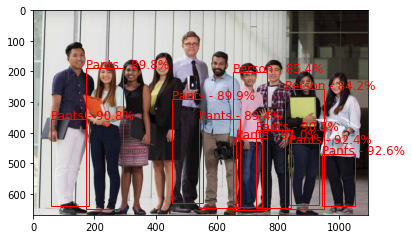

In [14]:
display_labelled_image(filename, labels)

---
# Detecting live images
---
Google Colab provides a function to capture live image from the webcam.

In [15]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Putting all the codes together to perform object detection on live images.

<IPython.core.display.Javascript object>

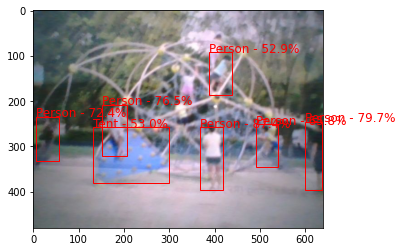

In [17]:
filename = course_path + "/captured_image.jpg"
take_photo(filename)
labels = detect_objects(filename)
display_labelled_image(filename, labels)

---
©Copyright 2021, Republic Polytechnic